In [1]:
from CoachAIUtils import *
import re
import pandas as pd
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import IPython.display as ht
from keras.callbacks import TensorBoard
from time import time
from ipywidgets import *
from sklearn.linear_model import LogisticRegression
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
import random as rn
import os
from keras import backend as K
from keras.models import load_model

jupy = False

if jupy: get_ipython().magic('matplotlib inline')

portpar = {
    "port0": 0,  # @param {type:"slider", min:-100, max:100, step:1}
    "porta": 3,  # @param {type:"slider", min:-100, max:100, step:1}
    "portb": 1,  # @param {type:"slider", min:-100, max:100, step:1}
    "portc": -1,  # @param {type:"slider", min:-100, max:100, step:1}
    "portd": -5,  # @param {type:"slider", min:-100, max:100, step:1}
    "ajalfa": 1.2,  # @param {type:"slider", min:0, max:10, step:0.1}
    "ajbeta": 1.1,  # @param {type:"slider", min:0, max:10, step:0.1}
    "ajgamma": 0.8,  # @param {type:"slider", min:0, max:10, step:0.1}
    "ajdelta": 0.4,  # @param {type:"slider", min:0, max:10, step:0.1}
    "ajalfabeta": 8,  # @param {type:"slider", min:-1000, max:1000, step:1}
    "ajbetagamma": -17,  # @param {type:"slider", min:-1000, max:1000, step:1}
    "ajgammadelta": -26,  # @param {type:"slider", min:-1000, max:1000, step:1}
    "componer": True,  # @param {type:"boolean"}
    "anticipar": True,  # @param {type:"boolean"}
    "determinista": False,
    "minportfolio": .5,
    "renorm": 1,
    "teamsize": 10,
    "runs": 11
}

if jupy:
    setpar = {}
else:
    setpar = {
        "trainsetlist": "0,1",
        "trainyearlist": "2007,2008,2009,2010,2011,2012,2013,2014",
        "modeltype": "LSTM",  # @param ["LSTM", "RNN", "Attention", "Red No Recurrente", "Boosting"]
        "eslabones": 3,  # @param {type:"slider", min:2, max:10, step:1}
        "look_back": 3,  # @param {type:"slider", min:2, max:100, step:1}
        "look_fwd": 0,  # @param {type:"slider", min:0, max:10, step:1}
        "runs": 1,  # @param {type:"slider", min:0, max:5, step:1}
        "overlap": True,  # @param {type:"boolean"}
        "shuffle": True,  # @param {type:"boolean"}
        "epochs": 10,  # @param {type:"slider", min:0, max:500, step:10}
        "batch_size": 200,  # @param {type:"slider", min:0, max:10000, step:100}
        "validation_split": 0.2,  # @param {type:"slider", min:0, max:1, step:0.1}
        "optimizador": "Adam",  # @param ["Adam", "SGD", "RMS", "Adagrad", "Adadelta", "Adamax", "Nadam"]
        "lr": 0.1,  # @param {type:"slider", min:0, max:1, step:0.001}
        "decay": 0.1,  # @param {type:"slider", min:0, max:1, step:0.001}
        "dropout": 0,  # @param {type:"slider", min:0, max:1, step:0.001}
        "recurrent_dropout": 0,  # @param {type:"slider", min:0, max:1, step:0.001}
        "determinista": False}

# In[2]:


# @markdown Mostrar todos los detalles:
debug = True  # @param {type:"boolean"}
logset = []
runs = []
grafancho = 12
grafalto = 6
loadfichport = ""
loadfichset = "20Oct19"
savefich = ""
lota = 1.3  # @param {type:"slider", min:0, max:10, step:0.1}
lotb = 1  # @param {type:"slider", min:0, max:10, step:0.1}
lotc = 0.5  # @param {type:"slider", min:0, max:10, step:0.1}
lotd = 0.1  # @param {type:"slider", min:0, max:10, step:0.1}

# Conectar a BD
con = conectamysql("mysql+pymysql://{}:{}@{}/{}".format(user, passwd, host, db))
dfhead = pd.read_sql("select distinct EASetName from easet", con)
df = pd.read_sql("select distinct ﻿EASetName, Modifications from easettrades", con)
easetlist = df["﻿EASetName"].unique()



# Selección de Datos
# ___________________________
# Sets a incluir en test:ptestsetlist
# 
# Años a incluir en test:ptestyearlist
# 


easetstest = []
yearstest = []
loadedsets = []
testsetlist = "0,1"
testyearlist = "2015,2016,2017,2018,2019"
dire=".\\"
trd = np.array(np.zeros((1, 10000, 70)), dtype=object)


def create_dataset(dataset, pcol, plback=2, plfwd=0, prun=easetstest):
    testx, testy, testadd, desctrain, desctest = [], [], [], [], []
    cols = {"easet": 0, "ticket": 1, "apertura": 4, "cierre": 5, "lote": 8, "pl": 28, "acc": 29}
    salto = 1 if setpar["overlap"] else setpar["eslabones"]
    lookback = plback * salto
    lookahead = plfwd * salto

    tot = 1
    for i in range(len(dataset)):
        for j in range(0, len(dataset[i]) - lookback - lookahead, salto):
            a = dataset[i, range(j, j + lookback, salto), pcol]
            b = dataset[i, j + lookback + lookahead, pcol]
            if b == 0.0 :
                continue
            c = dataset[i, j + lookback + lookahead, (cols["easet"], cols["easet"], cols["ticket"], cols["apertura"], cols["cierre"],
                                                      cols["lote"], cols["pl"], cols["acc"])]
            c[6] += sum(dataset[i, j + lookback + lookahead - salto:j + lookback + lookahead, cols["pl"]])
            c[3] = fechabuena(c[3])
            ano = c[3][:4]
            c[4] = fechabuena(c[4])
            c[1] = nombrebueno(df, c[1])
            desc = c[1] + "/" + ano

            if (c[0] in prun) and (ano in yearstest):
                testx.append(a)
                testy.append(b)
                testadd.append(c)
                if desc not in desctest:
                    desctrain.append(desc)
            tot += 1

    if debug:
        print("Sets con los que Graficará:", desctest)
    return np.array(testx), np.array(testy), np.array(testadd)

def generateruns(peasetstest, pteamsize, pruns):
    for i in range(pruns):
        oneset = peasetstest
        a = 0
        while len(oneset) > pteamsize:
            b = rand() * pteamsize / len(oneset) - .5
            if b > 0: oneset.remove(a)
            a = (a + 1) % len(oneset)
        nponeset = np.array(oneset, ndmin=2)

        locruns = np.vstack((locruns, nponeset)) if i > 0 else np.array(nponeset, ndmin=2)
    return locruns

def cargaparport(ptestsetlist, ptestyearlist, plota, plotb, plotc, plotd, pgrafancho, pgrafalto, pport0, pporta, pportb, pportc, pportd, pajalfa, pajbeta, pajgamma, pajdelta, pajalfabeta,
    pajbetagamma, pajgammadelta, pcomponer, panticipar, pminportfolio, pruns, pteamsize, prenorm, ploadfichport, ploadfichset):
    global portpar, loadfichport, loadfichset, trd, loadedsets, setpar, grafancho, grafalto, lota, lotb, lotc, lotd, model, runs

    portpar = {"port0": pport0, "porta": pporta, "portb": pportb,"portc": pportc, "portd": pportd, "ajalfa": pajalfa, "ajbeta": pajbeta, "ajgamma": pajgamma, "ajdelta": pajdelta,
        "ajalfabeta": pajalfabeta, "ajbetagamma": pajbetagamma, "ajgammadelta": pajgammadelta, "componer": pcomponer, "anticipar": panticipar, "minportfolio": pminportfolio, "renorm": prenorm, "runs": pruns, "teamsize": pteamsize}
    loadfichport = ploadfichport
    loadfichset = ploadfichset
    if loadfichport != "":
        portpar = json.load(open(dire + "portpar-" + loadfichport + ".json"))
        print ("Cargado "+ loadfichport)
    if loadfichset != "":
        setpar = json.load(open(dire + "setpar-" + loadfichset + ".json"))
        model = load_model(dire + loadfichset + ".h5")
        print ("Cargado "+ ploadfichset)

    for y in ptestsetlist.split(","):
        easetstest.append(easetlist[int(y)])

    for y in ptestyearlist.split(","):
        yearstest.append(y)

    if pteamsize < len(easetstest):
        runs = easetstest
    else:
        runs = generateruns(easetstest, pteamsize, pruns)

    trd = np.array(np.zeros((len(easetstest), 10000, 70)), dtype=object)
    dfmulti = ""
    for st in easetstest:
        dfmulti += "'{}',".format(st)

    dfmulti = dfmulti[:-1]
    print("Cargando {}".format(dfmulti))
    dftodos = pd.read_sql("select * from easettrades where ﻿EASetName IN ({}) ORDER BY 1, 3 ".format(dfmulti), con)

    i = 0
    for st in dftodos["﻿EASetName"].unique():
        dfsingle = dftodos[dftodos["﻿EASetName"] == st]
        trd[i, 0:dfsingle.shape[0], 0:dfsingle.shape[1]] = dfsingle.values
        i += 1

    lota = plota
    lotb = plotb
    lotc = plotc
    lotd = plotd
    grafancho = pgrafancho
    grafalto = pgrafalto

    return "Cargado"


Using TensorFlow backend.


# Datos de Set

## Selección de Datos
##  ___________________________
Sets a incluir en training:ptrainsetlist

Años a incluir en training:ptrainyearlist

Sets a incluir en test:ptestsetlist

Años a incluir en test:ptestyearlist
 
## Parámetros Set
## ______________
pmodeltype: Modelo

peslabones: Tipo de eslabon (eg: 5 mira los 5 ultimos trades)

plook_back: Longitud de la cadena (eg: 10 entrena con los ultimos 10 eslabones)

plook_fwd: Lag de la predicción (0 intenta predecir siguiente eslabon, 1 dos eslabones despues...)

pruns: Numero de veces que entrenamos

Eslabones solapados o secuenciales:poverlap

Si marcas multiyear, habra un grafico por set y no por año: pmultiyear

Nuevo lotaje:plota, plotb, plotc, plotd

Tamaño Gráficos:pgrafancho, pgrafalto
 
## Parametros de los modelos:
## __________________________
Número de pasadas:pepochs

Número de elementos en cada pasada:pbatch_size

% de los datos que se usan para validación:pvalidation_split

Optimizador: poptimizador

Learning Rate: Tamaño de la actualizacion en gradient descent:plr

Reduccion progresiva del learning rate:pdecay

Celdas a desactivar cada pasada del estado oculto para prevenir overfitting:pdropout

Celdas a desactivar de la "memoria" para prevenir overfitting:precurrent_dropout
 

In [2]:
interact_manual(cargaparport,
        ptestsetlist = testsetlist,
        ptestyearlist = testyearlist,
        plota=lota,  # @param {type:"slider", min:-100, max:100, step:1}
        plotb=lotb,  # @param {type:"slider", min:-100, max:100, step:1}
        plotc=lotc,  # @param {type:"slider", min:-100, max:100, step:1}
        plotd=lotd,  # @param {type:"slider", min:-100, max:100, step:1}
        pgrafancho=grafancho,  # @param {type:"slider", min:-100, max:100, step:1}
        pgrafalto=grafalto,  # @param {type:"slider", min:-100, max:100, step:1}
        pport0 = portpar["port0"],  # @param {type:"slider", min:-100, max:100, step:1}
        pporta = portpar["porta"],  # @param {type:"slider", min:-100, max:100, step:1}
        pportb = portpar["portb"],  # @param {type:"slider", min:-100, max:100, step:1}
        pportc = portpar["portc"],  # @param {type:"slider", min:-100, max:100, step:1}
        pportd = portpar["portd"],  # @param {type:"slider", min:-100, max:100, step:1}
        pajalfa = portpar["ajalfa"],  # @param {type:"slider", min:0, max:10, step:0.1}
        pajbeta = portpar["ajbeta"], # @param {type:"slider", min:0, max:10, step:0.1}
        pajgamma = portpar["ajgamma"],  # @param {type:"slider", min:0, max:10, step:0.1}
        pajdelta = portpar["ajdelta"],  # @param {type:"slider", min:0, max:10, step:0.1}
        pajalfabeta = portpar["ajalfabeta"], # @param {type:"slider", min:-1000, max:1000, step:1}
        pajbetagamma = portpar["ajbetagamma"],  # @param {type:"slider", min:-1000, max:1000, step:1}
        pajgammadelta = portpar["ajgammadelta"],  # @param {type:"slider", min:-1000, max:1000, step:1}
        pcomponer = portpar["componer"], # @param {type:"boolean"}
        panticipar = portpar["anticipar"],  # @param {type:"boolean"}
        pminportfolio = portpar["minportfolio"],
        pteamsize = portpar["teamsize"],
        pruns = portpar["runs"],
        prenorm = portpar["renorm"],
        ploadfichport = loadfichport,
        ploadfichset = loadfichset
)

print("Configuraciones de Sets")
for portfich in os.listdir(dire):
    if re.match("portpar.*.json", portfich):
        print(portfich[7:-5])


interactive(children=(Text(value='0,1', description='ptestsetlist'), Text(value='2015,2016,2017,2018,2019', de…

Configuraciones de Sets
-18oct19
-21Oct19


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Cargado 20Oct19
Cargando 'EA-A1v521012174692en3','EA-A1v521013202856uj3'
Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


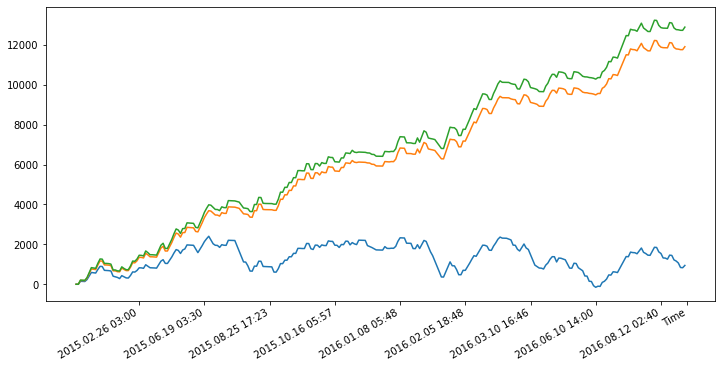

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


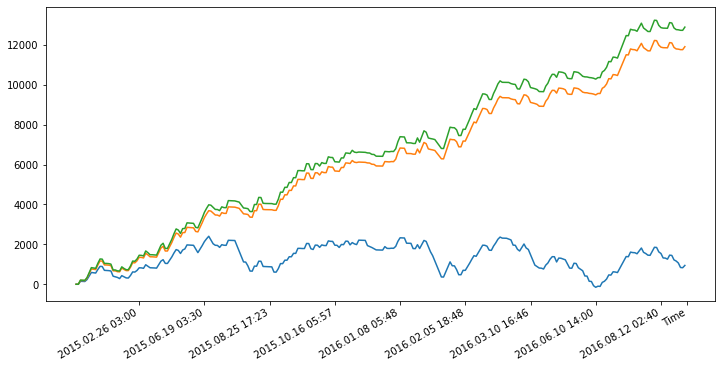

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


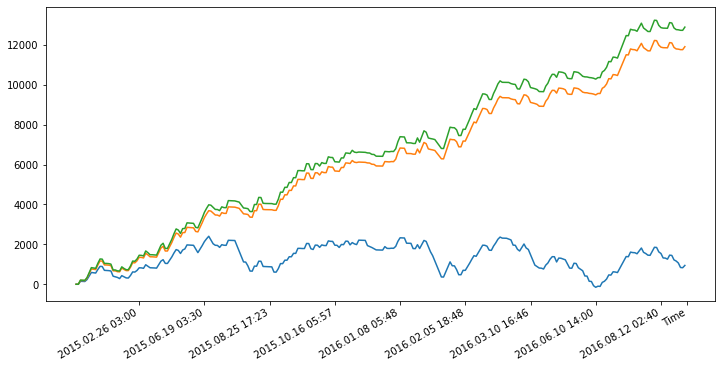

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


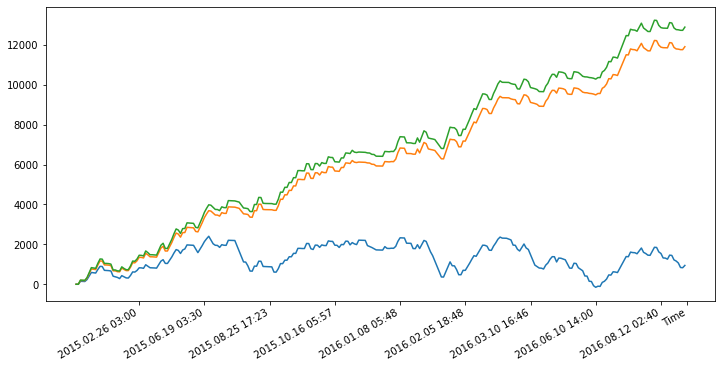

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


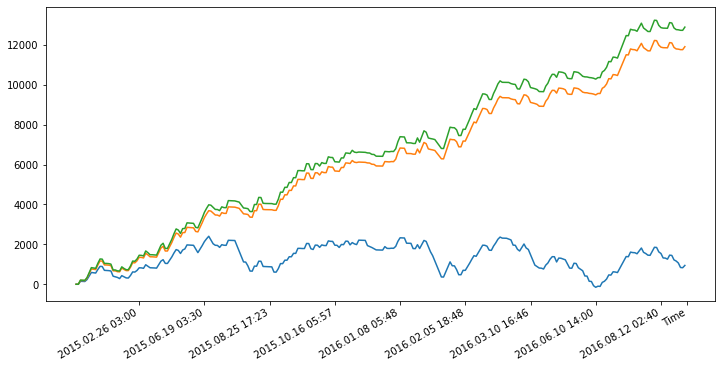

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


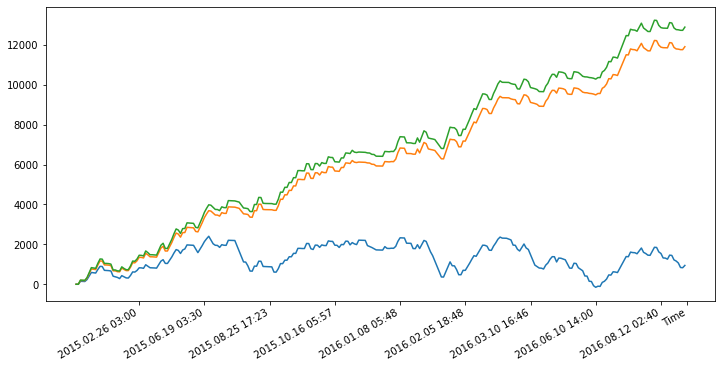

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


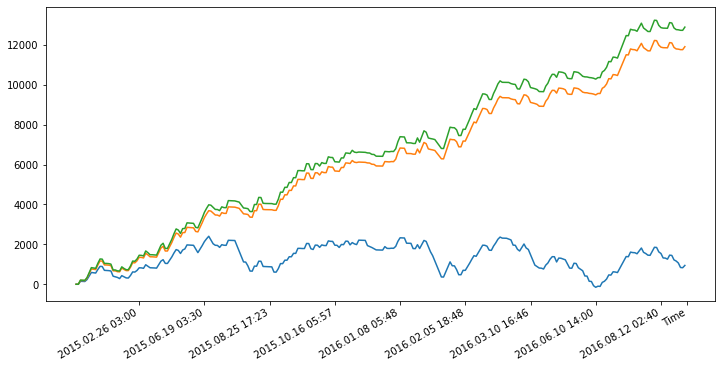

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


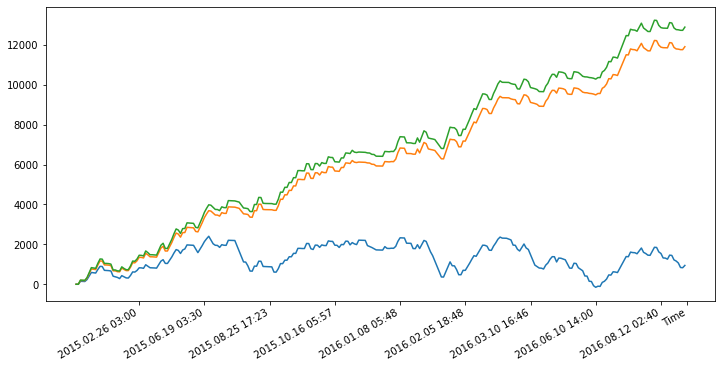

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


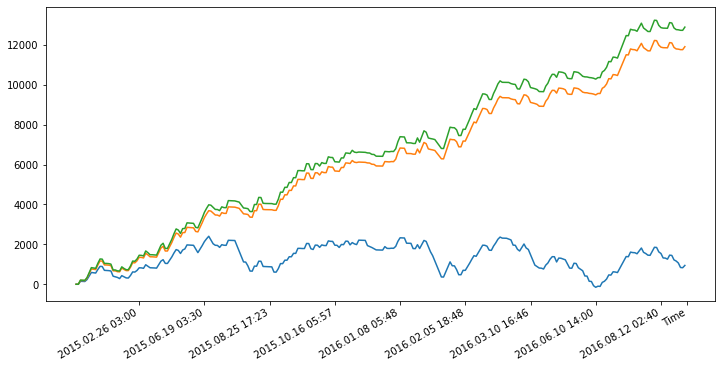

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


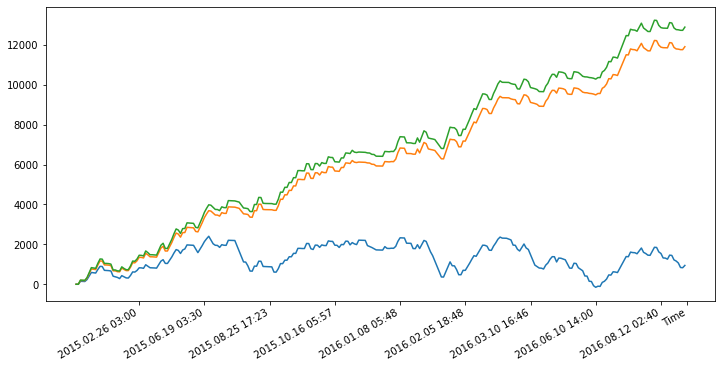

Sets con los que Graficará: []
(279, 3)
[['1' 'EA-A1-v5210-1217-4692-en-3']
 ['2' 'EA-A1-v5210-1320-2856-uj-3']]


<h2>Evolución del Portfolio</h2><h3>___________________________________________________</h3><h3>Ajustes: 0 Alfas - 281 Betas - 0 Gammas - 0 Deltas</h3><h3>48.04% Mejorados tras ajuste (135 mejorados de 281)</h3>
<table><tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr><tr><td>NP:</td><td>943.75$</td><td>11,905.55$ (1161%)</td><td>12,887.57$ (1265%)</td></tr><tr><td>Max Drawdown:</td><td style='color: red'>2,557.10$</td><td style='color: black'>822.55$ </td><td style='color: black'>886.86$ </td></tr><tr><td>PF:</td><td>1.07</td><td>2.37 (x2.21)</td><td>2.36 (x1.00)</td></tr><tr><td>PF Mejora:</td><td></td><td>-3.07</td><td>-2.44</td></tr><tr><td>EM:</td><td>3.36$</td><td>42.37$ (x12.62)</td><td>45.86$ (x13.66)</td></tr><tr><td>Ratio Máximo:</td><td>(252.98$/-271.65$)</td><td>(327.94$/-260.76$) </td><td>(356.05$/-289.73$) </td></tr><tr><td>Ratio Medio:</td><td>(168.99$/-157.76$)</td><td>(215.68$/-47.97$) </td><td>(234.14$/-52.28$) </td></tr></table>


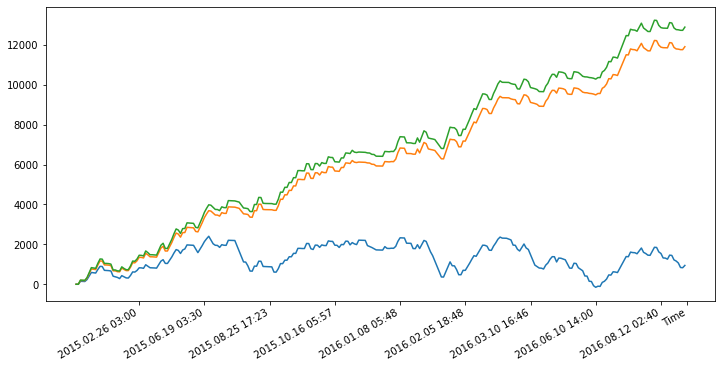

In [3]:

# In[5]:



def aplicapred(lote, letra):
    if letra == 1:
        newlot = lote * lota
    elif letra == 2:
        newlot = lote * lotb
    elif letra == 3:
        newlot = lote * lotc
    elif letra == 4:
        newlot = lote * lotd
    else:
        newlot = 0

    newlot = round(newlot, 2)
    return newlot




# Predecir Set


# In[11]:


def predice(pmodel, pxtest):
    if debug:
        print(pxtest.shape)
    if setpar["modeltype"] == "LSTM":
        pxtest = to_categorical(pxtest)
    y_pred = pmodel.predict(pxtest, verbose=(0 + debug * 2))

    pred = np.argmax(y_pred, axis=1)
    return pred


def construyeportante(pred, padd):
    portpred = np.array([], ndmin=2)
    idarr = np.arange(len(padd)).reshape((-1, 1))
    padd = np.append(padd, idarr, axis=1)
    evopen = padd[:, (1, 3, 8, 8, 5, 6)]
    evopen[:, 2] = "open"
    evclose = padd[:, (1, 4, 8, 8, 5, 6)]
    evclose[:, 2] = "close"
    evtodos = np.vstack((evopen, evclose))
    evtodos = sorted(evtodos, key=lambda x: x[1])
    maxoldpl, maxoldacc, maxolddraw, minoldpl, minoldacc, maxnewpl, maxnewacc, minnewpl, minnewacc, maxnewdraw, posoldacc, numposold, negoldacc, numnegold, posnewacc, numposnew, negnewacc, numnegnew, sumimprov, sumnonimprov = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    for y in evtodos:
        if portpred.size:
            indice = descsets[np.where(descsets == y[0])[0], 0]
            if indice.size and y[2] == "open":
                continue
            portpred = np.hstack((portpred, np.atleast_2d(np.array(portpred[:, -1]).reshape(-1, 1))))
            if indice.size == 0:
                portpred = np.vstack((portpred, portpred[-1]))
                portpred[-1, 0] = i
                portpred[-1, 1:] = 0
                descsets = np.vstack((descsets, [i, y[0]]))
                i += 1
                indice = [portpred.shape[0] - 12]
            accion = "Abre" if y[2] == "open" else "Cierra"
            pos = min(y[3] + 1, len(pred) - 1) if y[2] == "close" else y[3]
            portpred[colsport["Last"] -2 + int(indice[0]), -1] = pred[pos]
        else:
            portpred = np.array(
                [["Time", ""], ["Trade", ""], ["LotOrig", 0.], ["LotAprend", 0.], ["LotAjust", 0.], ["PLOrig", 0.], ["PLAprend", 0.],
                 ["PLAjust", 0.], ["DDOrigin", ""], ["AccOrig", 0.],
                 ["AccAprend", 0.], ["AccAjust", 0.], ["NomAjuste", 0], ["Ajuste", 0], [1, pred[y[3]]]]).astype("object")
            antoldacc, antnewacc = 0, 0
            descsets = np.array([1, y[0]], ndmin=2)
            indice = ['1']
            pos = y[3]
            accion = "Abre"
            i = 2
        portpred[colsport["Time"], -1] = y[1]
        portpred[colsport["Trade"], -1] = "Set {} ({} {}, Predice {})".format(indice[0], accion, y[3], pos)
        portpred[colsport["LotOrig"], -1] = y[4]
        portpred[colsport["LotAprend"], -1] = aplicapred(y[4], pred[y[3]])
        portpred[colsport["LotAjust"], -1] = portpred[colsport["LotOrig"], -1]
        portpred[colsport["PLOrig"], -1] = y[5]
        portpred[colsport["PLAprend"], -1] = round(portpred[colsport["PLOrig"], -1] * portpred[colsport["LotAprend"], -1] / portpred[colsport["LotOrig"], -1], 2)
        portpred[colsport["PLAjust"], -1] = portpred[colsport["PLOrig"], -1]
        portpred[colsport["DDOrigin"], -1] = ""
        portpred[colsport["AccOrig"], -1] = antoldacc + portpred[colsport["PLOrig"], -1] if y[2] == "close" else antoldacc
        antoldacc = portpred[colsport["AccOrig"], -1]
        portpred[colsport["AccAprend"], -1] = antnewacc + portpred[colsport["PLAprend"], -1] if y[2] == "close" else antnewacc
        antnewacc = portpred[colsport["AccAprend"], -1]
        portpred[colsport["AccAjust"], -1] = portpred[colsport["AccAprend"], -1]
        portpred[colsport["NomAjuste"], -1] = "@"
        portpred[colsport["Ajuste"], -1] = 1.
        maxoldpl = max(maxoldpl, portpred[colsport["PLOrig"], -1])
        maxoldacc = max(maxoldacc, antoldacc)
        maxolddraw = max(maxolddraw, maxoldacc - antoldacc)
        minoldpl = min(minoldpl, portpred[colsport["PLOrig"], -1])
        minoldacc = min(minoldpl, antoldacc)
        maxnewpl = max(maxnewpl, portpred[colsport["PLAprend"], -1])
        maxnewacc = max(maxnewacc, antnewacc)
        minnewpl = min(minnewpl, portpred[colsport["PLAprend"], -1])
        minnewacc = min(minnewacc, antnewacc)
        maxnewdraw = max(maxnewdraw, maxnewacc - antnewacc)
        posoldacc += portpred[colsport["PLOrig"], -1] if portpred[colsport["PLOrig"], -1] >= 0 else 0
        numposold += 1 if portpred[colsport["PLOrig"], -1] >= 0 else 0
        negoldacc += portpred[colsport["PLOrig"], -1] if portpred[colsport["PLOrig"], -1] < 0 else 0
        posnewacc += portpred[colsport["PLAprend"], -1] if portpred[colsport["PLAprend"], -1] >= 0 else 0
        numposnew += 1 if portpred[colsport["PLAprend"], -1] >= 0 else 0
        negnewacc += portpred[colsport["PLAprend"], -1] if portpred[colsport["PLAprend"], -1] < 0 else 0
        numnegnew += 1 if portpred[colsport["PLAprend"], -1] < 0 else 0
        sumimprov += portpred[colsport["PLAprend"], -1] if portpred[colsport["PLAprend"], -1] > portpred[colsport["PLOrig"], -1] else 0
        sumnonimprov += portpred[colsport["PLAprend"], -1] if portpred[colsport["PLAprend"], -1] <= portpred[colsport["PLOrig"], -1] else 0

    s = "<h2>Evolución del Portfolio</h2>"
    f = lambda x: chr(ord("A") + int(x) - 1)
    letvec = np.vectorize(f)
    di = {'0': portpar["port0"], 0: portpar["port0"], '1': portpar["porta"], 1: portpar["porta"], '2': portpar["portb"], 2: portpar["portb"], '3': portpar["portc"], 3: portpar["portc"], '4': portpar["portd"], 4: portpar["portd"]}
    mapdi = lambda x: di[x]
    comienzo = dameiniciomin(portpred, portpar["minportfolio"])
    combinacion = pd.DataFrame(portpred.T[comienzo:, colsport["Last"]+1:]).applymap(mapdi)
    combinacion = combinacion.sum(axis=1)
    alfas = combinacion.copy()
    ajnombres = alfas.copy()
    alfas[combinacion >= portpar["ajalfabeta"]] = portpar["ajalfa"]
    ajnombres[combinacion >= portpar["ajalfabeta"]] = "Alfa"
    numalfa = len(alfas[combinacion >= portpar["ajalfabeta"]])
    alfas[combinacion.between(portpar["ajbetagamma"], portpar["ajalfabeta"], inclusive=False)] = portpar["ajbeta"]
    ajnombres[combinacion.between(portpar["ajbetagamma"], portpar["ajalfabeta"], inclusive=False)] = "Beta"
    numbeta = len(alfas[combinacion.between(portpar["ajbetagamma"], portpar["ajalfabeta"], inclusive=False)])
    alfas[combinacion.between(portpar["ajgammadelta"], portpar["ajbetagamma"], inclusive=True)] = portpar["ajgamma"]
    ajnombres[combinacion.between(portpar["ajgammadelta"], portpar["ajbetagamma"], inclusive=True)] = "Gamma"
    numgamma = len(alfas[combinacion.between(portpar["ajgammadelta"], portpar["ajbetagamma"], inclusive=True)])
    alfas[combinacion <= portpar["ajgammadelta"]] = portpar["ajdelta"]
    ajnombres[combinacion <= portpar["ajgammadelta"]] = "Delta"
    numdelta = len(alfas[combinacion <= portpar["ajgammadelta"]])
    portpred[colsport["Ajuste"], comienzo:] = alfas
    portpred[colsport["NomAjuste"], comienzo:] = ajnombres
    if portpar["componer"]:
        portpred[colsport["LotAjust"], 1:] = [np.round(portpred[colsport["LotAprend"], i] * portpred[colsport["Ajuste"], i], 2) for i in range(1, len(portpred[colsport["LotAjust"]]))]
    else:
        portpred[colsport["LotAjust"], 1:] = [np.round(portpred[colsport["LotOrig"], i] * portpred[colsport["Ajuste"], i], 2) for i in range(1, len(portpred[colsport["LotAjust"]]))]
    accaj, maxajpl, maxajacc, minajpl, minajacc, maxajdraw, improv, sumajimprov, sumajnonimprov, posajacc, numposaj, negajacc, numnegaj = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    for i in range(1, len(portpred[colsport["LotAjust"]])):
        portpred[colsport["PLAjust"], i] = round(portpred[colsport["PLOrig"], i] / portpred[colsport["LotOrig"], i] * portpred[4, i], 2)
        accaj = accaj + portpred[colsport["PLAjust"], i] if "Cierra" in portpred[colsport["Trade"], i] else accaj
        portpred[colsport["AccAjust"], i] = accaj
        maxajpl = max(maxajpl,  portpred[colsport["PLAjust"], i])
        maxajacc = max(maxajacc, accaj)
        minajpl = min(minajpl, portpred[colsport["PLAjust"], i])
        minajacc = min(minajacc, accaj)
        maxajdraw = max(maxajdraw, maxajacc - accaj)
        improv = improv + 1 if portpred[colsport["PLAjust"], i] > portpred[colsport["PLOrig"], i] / portpred[colsport["LotOrig"], i] * portpred[colsport["LotAprend"], i] else improv
        sumajimprov = sumajimprov + portpred[colsport["PLAjust"], i] if portpred[colsport["PLAjust"], i] > portpred[colsport["PLOrig"], i] / portpred[colsport["LotOrig"], i] * portpred[colsport["LotAprend"], i] else sumajimprov
        sumajnonimprov = sumajnonimprov + portpred[colsport["PLAjust"], i] if portpred[colsport["PLAjust"], i] <= portpred[colsport["PLOrig"], i] / portpred[colsport["LotOrig"], i] * portpred[colsport["LotAprend"], i] else sumajnonimprov
        posajacc += portpred[colsport["PLAjust"], i] if portpred[colsport["PLAjust"], i] >= 0 else 0
        numposaj += 1 if portpred[colsport["PLAjust"], i] >= 0 else 0
        negajacc += portpred[colsport["PLAjust"], i] if portpred[colsport["PLAjust"], i] < 0 else 0
        numnegaj += 1 if portpred[colsport["PLAjust"], i] < 0 else 0

    letras = letvec(portpred.T[1:, colsport["Last"]+1:])
    for i in range(colsport["Last"],-1,-1):
        letras = np.hstack((portpred[i, 1:].reshape((-1, 1)), letras))

    print(descsets)
    cabe = np.concatenate((portpred.T[0, :colsport["Last"]+1], descsets[:, 0]))
    ht.display(ht.HTML(pd.DataFrame(data=letras, columns=cabe).to_html(float_format=lambda x: '%6.2f' % x)))
    s += "<h3>___________________________________________________</h3>"
    s += "<h3>Ajustes: {} Alfas - {} Betas - {} Gammas - {} Deltas</h3>".format(numalfa, numbeta, numgamma, numdelta)
    s += "<h3>{:.2f}% Mejorados tras ajuste ({} mejorados de {})</h3>".format(improv * 100 / len(letras), improv,
                                                                              len(letras))

    if jupy:
        ht.display(ht.HTML(s))
    else:
        print(s)

    s = "<table>"
    s += "<tr><td></td><td>Original</td><td>Aprendido</td><td>Ajustado</td></tr>"
    s += "<tr><td>NP:</td><td>{:,.2f}$</td><td>{:,.2f}$ ({}%)</td><td>{:,.2f}$ ({}%)</td></tr>".format(antoldacc, antnewacc,
                                                                                                    int((
                                                                                                                antnewacc / antoldacc - 1) * 100),
                                                                                                    accaj, int(
            (accaj / antoldacc - 1) * 100))
    s += "<tr><td>Max Drawdown:</td><td style='color: {}'>{:,.2f}$</td><td style='color: {}'>{:,.2f}$ </td><td style='color: {}'>{:,.2f}$ </td></tr>".format(drawcolor(maxolddraw), maxolddraw,
                                                                                                    drawcolor(maxnewdraw), maxnewdraw,
                                                                                                    drawcolor(maxajdraw), maxajdraw)
    s += "<tr><td>PF:</td><td>{:.2f}</td><td>{:.2f} (x{:.2f})</td><td>{:.2f} (x{:.2f})</td></tr>".format(
        - posoldacc / negoldacc, - posnewacc / negnewacc, (posnewacc / negnewacc) / (posoldacc / negoldacc),
        - posajacc / negajacc, (posajacc / negajacc) / (posajacc / negajacc))
    s += "<tr><td>PF Mejora:</td><td></td><td>{:.2f}</td><td>{:.2f}</td></tr>".format(sumimprov / sumnonimprov, sumajimprov / sumajnonimprov)
    s += "<tr><td>EM:</td><td>{:,.2f}$</td><td>{:,.2f}$ (x{:.2f})</td><td>{:,.2f}$ (x{:.2f})</td></tr>".format(
        antoldacc / len(letras), antnewacc / len(letras), (antnewacc / len(letras)) / (antoldacc / len(letras)),
        accaj / len(letras), (accaj / len(letras)) / (antoldacc / len(letras)))
    s += "<tr><td>Ratio Máximo:</td><td>({:,.2f}$/{:,.2f}$)</td><td>({:,.2f}$/{:,.2f}$) </td><td>({:,.2f}$/{:,.2f}$) </td></tr>".format(
        maxoldpl, minoldpl, maxnewpl, minnewpl, maxajpl, minajpl)
    s += "<tr><td>Ratio Medio:</td><td>({:,.2f}$/{:,.2f}$)</td><td>({:,.2f}$/{:,.2f}$) </td><td>({:,.2f}$/{:,.2f}$) </td></tr>".format(
        posoldacc / numposold, negoldacc / numposold, posnewacc / numposnew, negnewacc / numnegnew, posajacc / numposaj,
        negajacc / numnegaj)
    s += "</table>"
    if jupy:
        ht.display(ht.HTML(s))
    else:
        print(s)

    fig, ax = plt.subplots()
    fig.set_size_inches(grafancho, grafalto)
    ax.plot(portpred[colsport["Time"], 1:], portpred[colsport["AccOrig"], 1:])
    ax.plot(portpred[colsport["Time"], 1:], portpred[colsport["AccAprend"], 1:])
    ax.plot(portpred[colsport["Time"], 1:], portpred[colsport["AccAjust"], 1:])
    plt.minorticks_off()
    ax.set_xticks(portpred[colsport["Time"], ::30])
    ax.set_xticklabels(portpred[colsport["Time"], ::30])
    fig.autofmt_xdate()
    plt.show()
    return portpred

if not jupy:
    cargaparport(testsetlist, testyearlist, lota, lotb, lotc, lotd, grafancho, grafalto, portpar["port0"], portpar["porta"],
                 portpar["portb"], portpar["portc"], portpar["portd"], portpar["ajalfa"], portpar["ajbeta"], portpar["ajgamma"], portpar["ajdelta"], portpar["ajalfabeta"],
                 portpar["ajbetagamma"], portpar["ajgammadelta"], portpar["componer"], portpar["anticipar"], portpar["minportfolio"], portpar["runs"], portpar["teamsize"], portpar["renorm"], loadfichport,
                 loadfichset)

port = []
i = 0
if len(setpar) > 0:
    trd = eslabones2numbers(trd)

    for run in runs:
        X_test, y_test, y_add = create_dataset(trd, 17 + setpar["eslabones"], plback=setpar["look_back"], plfwd=setpar["look_fwd"], prun=run)

        if len(y_test) == 0:
            print("No hay datos de test, revisa sets y años pls")
            exit(0)

        pred = predice(model, X_test)
        port = np.vstack((port, construyeportante(pred, y_add))) if i > 0 else construyeportante(pred, y_add)
        i += 1
else:
    print("Selecciona Configuracion y Sets de Test")


## Si no sale nada, dar a Run All Above
## Despues de cargar una configuracion, dar al play en la celda de parametros para refrescar

In [4]:

def grabafich(psavefich):
    global savefich

    savefich = psavefich
    if psavefich != "":
        savejson(setpar, dire + "portpar-" + psavefich)
        pd.DataFrame(port).to_csv(dire + "portdat-" + psavefich + ".csv", sep=";")
        print("Grabado " + psavefich)

    return "Grabado"
# Section [4]





In [5]:
interact_manual(grabafich,
                psavefich= savefich)


interactive(children=(Text(value='', description='psavefich'), Button(description='Run Interact', style=Button…

<function __main__.grabafich>